In [19]:
import ROOT as r
import math
import array
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

#______________Add include directory_______________
current_dir = os.getcwd()
include_dir = os.path.join(current_dir, '../include')
sys.path.insert(0, include_dir)
#__________________________________________________
import ERROR
import CONFIG
import DBPARSE
from ASYMMETRY import *
from UTILITIES import *
from SIMFITS import DistributionFits
from ROOT import gStyle, TChain, TH1F, TCanvas, TLegend


from joblib import Parallel, delayed

In [20]:
pas="1"
config="3"

# Cuts

In [21]:
W2min=CONFIG.Function_JSON("W2min",f"../config/cuts{config}.cfg")
W2max=CONFIG.Function_JSON("W2max",f"../config/cuts{config}.cfg")
dxmin=CONFIG.Function_JSON("dxmin",f"../config/cuts{config}.cfg")
dxmax=CONFIG.Function_JSON("dxmax",f"../config/cuts{config}.cfg")
dymin=CONFIG.Function_JSON("dymin",f"../config/cuts{config}.cfg")
dymax=CONFIG.Function_JSON("dymax",f"../config/cuts{config}.cfg")
dybgmin=CONFIG.Function_JSON("dybgmin",f"../config/cuts{config}.cfg")
dybgmax=CONFIG.Function_JSON("dybgmax",f"../config/cuts{config}.cfg")
coinmin=CONFIG.Function_JSON("coinmin",f"../config/cuts{config}.cfg")
coinmax=CONFIG.Function_JSON("coinmax",f"../config/cuts{config}.cfg")

print(f'W2min: {W2min}')
print(f'W2max: {W2max}')
print(f'dxmin: {dxmin}')
print(f'dxmax: {dxmax}')
print(f'dymin: {dymin}')
print(f'dymax: {dymax}')
print(f'dybgmin: {dybgmin}')
print(f'dybgmax: {dybgmax}')
print(f'Coin Min: {coinmin} Coin Max: {coinmax}')

W2min: 0
W2max: 1.4947
dxmin: -0.4
dxmax: 0.402
dymin: -0.7895
dymax: 0.7895
dybgmin: -1.2
dybgmax: 1.2
Coin Min: 82 Coin Max: 106


In [22]:
cut="w2"
value=[W2min,W2max]

In [23]:
#w2
valuemax=np.linspace(.2,2,80)
valuemin=np.linspace(0,0,80)

value=np.transpose(np.stack([valuemin,valuemax],axis=0))

# Calculate Raw Asymmetry, Fit dx and determine fBG, Calc Aphys

In [24]:
def Function_APHYSSENS(config,cut,value):
    import ROOT as r
    import math
    import array
    import os
    import sys
    import matplotlib.pyplot as plt
    import numpy as np

    #______________Add include directory_______________
    current_dir = os.getcwd()
    include_dir = os.path.join(current_dir, '../include')
    sys.path.insert(0, include_dir)
    #__________________________________________________
    import ERROR
    import CONFIG
    import DBPARSE
    import ASYMMETRY 
    import UTILITIES 
    from SIMFITS import DistributionFits
    from ROOT import gStyle, TChain, TH1F, TCanvas, TLegend


    from joblib import Parallel, delayed
    
    dxmin=CONFIG.Function_JSON("dxmin",f"../config/cuts{config}.cfg")
    dxmax=CONFIG.Function_JSON("dxmax",f"../config/cuts{config}.cfg")
    lower_bound=dxmin
    upper_bound=dxmax
    Raw=ASYMMETRY.Function_ASYMMETRYSENS(config,cut,value)
    print("Raw Asymmetry Calculated")
    
    Fit=ASYMMETRY.Function_FITDXSENS(config,cut,value)
    print("dx Histogram Fit Completed")
    
    data,bg,totalFit,simp,simn=Fit
    bin_centers,bin_contents=bg
    numBG=np.sum(bin_contents[(bin_centers >= lower_bound) & (bin_centers <= upper_bound)])
    bin_centers,bin_contents=data
    numTotal=np.sum(bin_contents[(bin_centers >= lower_bound) & (bin_centers <= upper_bound)])
    fbg=np.round(numBG/numTotal,5)
    print("Background Fraction Determined")
    
    Phys=ASYMMETRY.Function_APHYS(config,pas,Raw,fbg)
    print("Aphys Calculated")
    
    weighted_A,weighted_A_E,fbg=Phys
    print('Returned: Aphys, Aphys_E, fbg, cut, cutvalue')
    return weighted_A,weighted_A_E,fbg,cut,value

In [25]:
#Results=Function_APHYSSENS(config,cut,value)

In [ ]:
%%time
n_jobs = -1  # Use all available CPU cores
Results = Parallel(n_jobs=n_jobs)(delayed(Function_APHYSSENS)(config,cut,val) for (val) in value)



# rawA

# Calculate $A_{\text{Phys}}$

In [16]:

newA=np.array(A)
newYield=np.array(Y)

weightedSum=0
sumWeights=0


polsum=np.empty(0)

precorrection=0
precorrectionW=0
for i in range(0,len(newA)):
    
    PbE=.03*beamPol[i]/100
    PtE=.03*he3Pol[i]/100
    precorrection+=newA[i]*newYield[i]
    precorrectionW+=newYield[i]
    calculate=ERROR.Function_WEIGHTEDAVERAGEAPHYS(newA[i],fA,f,fnitro,beamPol[i]/100,Pneutron,he3Pol[i]/100,AE[i],fAE,fE,Efnitro,PbE,Eneutron,PtE)
    w=calculate[0]
    w_sig= calculate[1] 
    weightedSum+=(w/(w_sig**2))
    sumWeights+=1/(w_sig**2)
    


    
weighted_A=weightedSum/sumWeights
weighted_A_E=math.sqrt(1/sumWeights)


A_phys= -0.29361 +/- 0.04284


<ErrorbarContainer object of 3 artists>

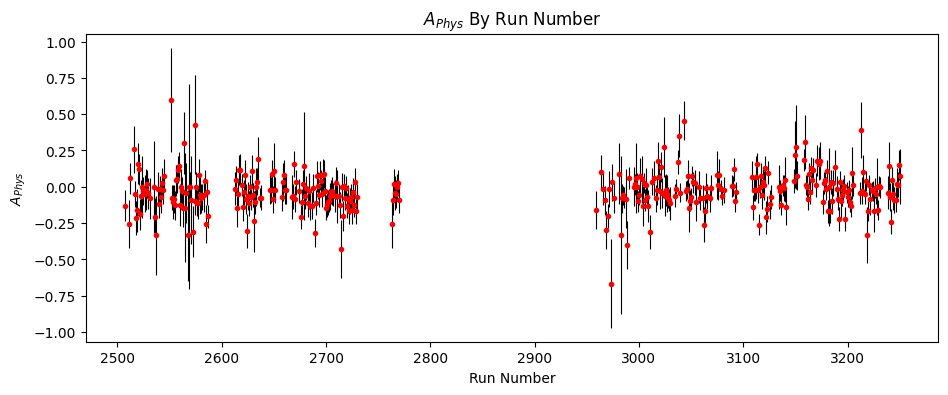

In [22]:
print(f'A_phys= {np.round(weighted_A,5)} +/- {np.round(weighted_A_E,5)}')

plt.figure(figsize=(11,4))
plt.title("$A_{Phys}$ By Run Number")
plt.xlabel("Run Number")
plt.ylabel("$A_{Phys}$")
plt.errorbar(runs,A,yerr=AE,fmt='.',ecolor='black',color='red',lw=.8)